<a href="https://colab.research.google.com/github/An-Dongsun/Section3-Project/blob/main/%EB%AA%A8%EB%8D%B8_%ED%94%BC%ED%81%B4%EB%A7%81_%26_%EC%84%B1%EB%8A%A5%EC%B8%A1%EC%A0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Google Colab을 사용하는 경우 해당 셀을 실행하세요
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install markupsafe == 2.0.1
    !pip install --upgrade pandas-profiling
    !pip install pdpbox
    !pip install shap
    !pip install plotly
    !pip install cufflinks
    !pip install pyyaml==5.4.1
    !pip install -U imbalanced-learn

In [2]:
import sqlite3

import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import xgboost
import eli5
import shap

import warnings

from markupsafe import escape
from pandas_profiling import ProfileReport

from ipywidgets import interact, fixed

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform

from sklearn.pipeline import make_pipeline, Pipeline
from category_encoders import OneHotEncoder, OrdinalEncoder, TargetEncoder
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, plot_confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, log_loss

from sklearn.inspection import permutation_importance

from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_isolate, pdp_interact, pdp_interact_plot, pdp_plot

from sklearn.model_selection import cross_val_score
warnings.filterwarnings(action='ignore')

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


In [74]:
# 데이터베이스에 접속한다.
con = sqlite3.connect("/content/Diabetes.db")

In [75]:
# pandas의 read_sql함수를 이용해서 데이터베이스를 데이터프레임의 형태로 불러온다.
Diabetes = pd.read_sql("SELECT * FROM Diabetes_ML", con, index_col=None)

In [76]:
# index column을 제거해준다.
Diabetes = Diabetes.drop(columns = ['index'])
Diabetes

,Age,Sex,BMI,GenHlth,PhysHlth,MentHlth,PhysActivity,DiffWalk,Smoker,Fruits,Veggies,HighBP,CholCheck,HighChol,Stroke,HeartDiseaseorAttack,AnyHealthcare,NoDocbcCost,Diabetes_012
0,9.0,0.0,40.0,5.0,15.0,18.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1,7.0,0.0,25.0,3.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,9.0,0.0,28.0,5.0,30.0,30.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
3,11.0,0.0,27.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,11.0,0.0,24.0,2.0,0.0,3.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228588,5.0,1.0,45.0,3.0,5.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
228589,11.0,0.0,18.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,2.0
228590,2.0,0.0,28.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
228591,7.0,1.0,23.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [77]:
# feature들중 AnyHealthcare, CholCheck, NoDocbcCost은 제거해준다.
Diabetes = Diabetes.copy().drop(columns = ['AnyHealthcare', 'CholCheck', 'NoDocbcCost'])

In [78]:
Diabetes

,Age,Sex,BMI,GenHlth,PhysHlth,MentHlth,PhysActivity,DiffWalk,Smoker,Fruits,Veggies,HighBP,HighChol,Stroke,HeartDiseaseorAttack,Diabetes_012
0,9.0,0.0,40.0,5.0,15.0,18.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
1,7.0,0.0,25.0,3.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9.0,0.0,28.0,5.0,30.0,30.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
3,11.0,0.0,27.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
4,11.0,0.0,24.0,2.0,0.0,3.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228588,5.0,1.0,45.0,3.0,5.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
228589,11.0,0.0,18.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0
228590,2.0,0.0,28.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
228591,7.0,1.0,23.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0


In [79]:
#target을 설정해준다.
target = 'Diabetes_012'

#데이터를 훈련/테스트 세트로 분리한다.(train/test = 90%/10%의 비율로 나누어 주었다.)
train, test = train_test_split(Diabetes, train_size = 0.90, test_size = 0.10,
                               stratify = Diabetes[target], random_state = 42)

In [80]:
#target과 학습할 feature를 분리해준다.
y_train = train[target]
X_train = train.copy().drop(columns = [target])

y_test = test[target]
X_test = test.copy().drop(columns = [target])

In [107]:
%%time
# encoder, imputer를 preprocessing으로 묶었다. 후에 eli5 permutation 계산에 사용한다.
pipe = LGBMClassifier(random_state = 42,
                            n_jobs = -1,
                            num_class = 3,
                            application = 'multiclass',
                            is_unbalance = True,
                            learning_rate = 0.01,
                            class_weight = 'balanced',
                            metric = 'multi_logloss',
                            lbgm__max_depth = 14,
                            lbgm__n_estimators = 747,
                            lbgm__num_leaves = 90
                            )

# 학습을 진행한다.
pipe.fit(X_train, y_train);

CPU times: user 22.4 s, sys: 111 ms, total: 22.5 s
Wall time: 14.2 s


In [108]:
# 학습한 모델을 피클링 해준다.
with open('model.pkl','wb') as pickle_file:
    pickle.dump(pipe, pickle_file)

In [109]:
pipe_LGBM = None
with open('model.pkl','rb') as pickle_file:
   pipe_LGBM = pickle.load(pickle_file)

In [110]:
print('훈련 정확도: ', pipe_LGBM.score(X_train, y_train))
print('검증 정확도: ', pipe_LGBM.score(X_test, y_test))

훈련 정확도:  0.6080356578672357
검증 정확도:  0.6016185476815398


In [111]:
y_proba = pipe_LGBM.predict_proba(X_test)
# 사이킷런 결과 확인
sklearn_reslt = log_loss(y_test, y_proba)
print("sklearn_reslt", sklearn_reslt)

sklearn_reslt 0.9562615853016352


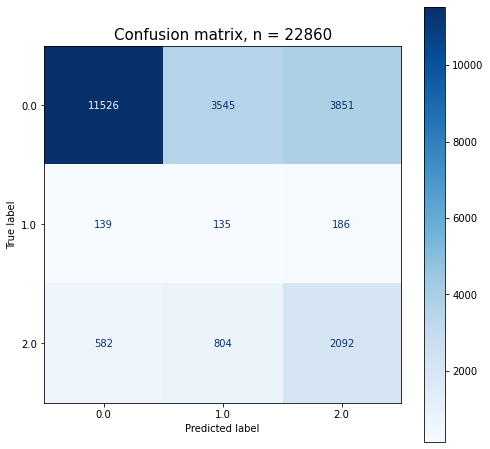

In [112]:
fig, ax = plt.subplots(figsize=(8,8))
pcm = plot_confusion_matrix(pipe_LGBM, # 분류 모델
                            X_test, y_test, # 예측 데이터와 예측값의 정답
                            cmap = plt.cm.Blues, # 컬러맵(plt.cm.Reds, plt.cm.rainbow 등이 있음)
                            normalize = None, #'true', 'pred', 'all' 중에서 지정 가능. default=None
                            ax = ax)
plt.title(f'Confusion matrix, n = {len(y_test)}', fontsize = 15)
plt.show()

In [113]:
y_pred = pipe_LGBM.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.61      0.74     18922
         1.0       0.03      0.29      0.05       460
         2.0       0.34      0.60      0.44      3478

    accuracy                           0.60     22860
   macro avg       0.44      0.50      0.41     22860
weighted avg       0.83      0.60      0.68     22860



In [114]:
roc_auc_score(y_test, pipe_LGBM.predict_proba(X_test), multi_class='ovr', average='macro')

0.7368661638982822

In [115]:
classification_report(y_test, pipe_LGBM.predict(X_test), output_dict=True, target_names=[0, 1, 2])

{0: {'f1-score': 0.7395809939362828,
  'precision': 0.9411284396178656,
  'recall': 0.6091322270373111,
  'support': 18922},
 1: {'f1-score': 0.0546116504854369,
  'precision': 0.030107047279214986,
  'recall': 0.29347826086956524,
  'support': 460},
 2: {'f1-score': 0.43551576975122314,
  'precision': 0.3413281122532224,
  'recall': 0.60149511213341,
  'support': 3478},
 'accuracy': 0.6016185476815398,
 'macro avg': {'f1-score': 0.4099028047243143,
  'precision': 0.4375211997167677,
  'recall': 0.5013685333467621,
  'support': 22860},
 'weighted avg': {'f1-score': 0.679536166827664,
  'precision': 0.8315407152499737,
  'recall': 0.6016185476815398,
  'support': 22860}}